In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import cPickle as pickle
sys.path.insert(0,"../python/rrvf2017/")
import rrvf_model as rrvf
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Mean of models

In [84]:
def simple_mean(files):
    lst=[pd.read_csv(fname,index_col=0) for fname in files]
    df=0
    for u in lst:
        df=df+np.log1p(u)
    df=df/len(lst)
    df=np.expm1(df)
    return df

In [87]:
!ls ../submission/ -alrt |tail

-rw-rw-r--  1 bo bo  336995 Feb  4 06:17 3002nb_lstm_fold3_False_d478.csv.gz
-rw-rw-r--  1 bo bo  336838 Feb  4 06:25 3002nb_lstm_fold4_False_d478.csv.gz
-rw-rw-r--  1 bo bo  336972 Feb  4 08:56 3002nb_lstm_foldmean_False_d478.csv.gz
drwxrwxr-x 11 bo bo    4096 Feb  4 10:13 ..
-rw-rw-r--  1 bo bo  259480 Feb  4 15:14 l2_3000_ridge_fold0_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259552 Feb  4 15:14 l2_3000_ridge_fold1_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259671 Feb  4 15:14 l2_3000_ridge_fold2_False_d478.csv.gz
-rw-rw-r--  1 bo bo  259684 Feb  4 15:14 l2_3000_ridge_fold3_False_d478.csv.gz
drwxrwxr-x  2 bo bo    4096 Feb  4 15:14 .
-rw-rw-r--  1 bo bo  259565 Feb  4 15:14 l2_3000_ridge_fold4_False_d478.csv.gz


In [92]:
name='l2_3006_xgb_fold{}_False_d478.csv.gz'  
files=['../submission/'+name.format(i) for i in range(5)]
u=simple_mean(files)

In [93]:
u.to_csv("../submission/"+ name.format('mean'),compression='gzip')

In [13]:
for v in [0.495,0.485,0.475,0.465]:
    print v, np.sqrt(1-v**2/0.65241814)

0.495 0.790212402991
0.485 0.799660355031
0.475 0.808808489759
0.465 0.817666870392


# weighted 

In [3]:
from multiprocessing import Pool

In [4]:
filenames=!ls *.pkl|grep fold4
filenames=[u.replace("fold4",'fold{}') for u in filenames]
filenames

['3000eb_ridge_fold{}_True_d478.pkl',
 '3000_ridge_fold{}_False_d478.pkl',
 '3001eb_lgb_fold{}_True_d478.pkl',
 '3001_lgb_fold{}_False_d478.pkl',
 '3002_lstm_fold{}_False_d478.pkl',
 '3002nb_lstm_fold{}_False_d478.pkl',
 '3003_conv_fold{}_False_d478.pkl',
 '3003nb_conv_fold{}_False_d478.pkl',
 '3005_rf_fold{}_False_d478.pkl',
 '3006_xgb_fold{}_False_d478.pkl']

In [5]:
def f(fname):
    return [ pickle.load(open(fname.format(i))) for i in range(5)]

In [6]:
p = Pool(4)

In [7]:
res=p.map(f, filenames)

In [8]:
pkldata=dict(zip(filenames,res))

In [8]:
#pkldata={fname: [ pickle.load(open(fname.format(i))) for i in range(5)] for fname in filenames}

In [9]:
p.close()

In [10]:
pkldata.keys()

['3003nb_conv_fold{}_False_d478.pkl',
 '3005_rf_fold{}_False_d478.pkl',
 '3001eb_lgb_fold{}_True_d478.pkl',
 '3002nb_lstm_fold{}_False_d478.pkl',
 '3000eb_ridge_fold{}_True_d478.pkl',
 '3002_lstm_fold{}_False_d478.pkl',
 '3006_xgb_fold{}_False_d478.pkl',
 '3003_conv_fold{}_False_d478.pkl',
 '3000_ridge_fold{}_False_d478.pkl',
 '3001_lgb_fold{}_False_d478.pkl']

In [11]:
def get_valid_data(fname,offset,fold,return_test=False):
    validpred,testpred=pkldata[fname][fold][offset]
    validdf=pd.DataFrame({"ytrue":np.squeeze(validpred[0]),fname:np.squeeze(validpred[2])},
                         index=[tuple(u) for u in validpred[1]])
    testdf=pd.DataFrame({ fname:np.squeeze(testpred[0])},index=  testpred[1]) if return_test else None
    return validdf,testdf

In [12]:
def show_valid(fold):
    d={}
    for fname in pkldata.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=get_valid_data(fname,offset,fold)
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                #print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

3003nb_conv_fold{}_False_d478.pkl
3005_rf_fold{}_False_d478.pkl
3001eb_lgb_fold{}_True_d478.pkl
3002nb_lstm_fold{}_False_d478.pkl
3000eb_ridge_fold{}_True_d478.pkl
3002_lstm_fold{}_False_d478.pkl
3006_xgb_fold{}_False_d478.pkl
3003_conv_fold{}_False_d478.pkl
3000_ridge_fold{}_False_d478.pkl
3001_lgb_fold{}_False_d478.pkl
{0: '3000_ridge_fold{}_False_d478.pkl', 1: '3000eb_ridge_fold{}_True_d478.pkl', 2: '3001_lgb_fold{}_False_d478.pkl', 3: '3001eb_lgb_fold{}_True_d478.pkl', 4: '3002_lstm_fold{}_False_d478.pkl', 5: '3002nb_lstm_fold{}_False_d478.pkl', 6: '3003_conv_fold{}_False_d478.pkl', 7: '3003nb_conv_fold{}_False_d478.pkl', 8: '3005_rf_fold{}_False_d478.pkl', 9: '3006_xgb_fold{}_False_d478.pkl'}


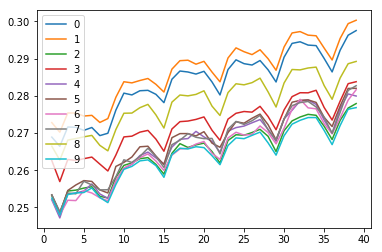

In [14]:
a=show_valid(0)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

3003nb_conv_fold{}_False_d478.pkl
3005_rf_fold{}_False_d478.pkl
3001eb_lgb_fold{}_True_d478.pkl
3002nb_lstm_fold{}_False_d478.pkl
3000eb_ridge_fold{}_True_d478.pkl
3002_lstm_fold{}_False_d478.pkl
3006_xgb_fold{}_False_d478.pkl
3003_conv_fold{}_False_d478.pkl
3000_ridge_fold{}_False_d478.pkl
3001_lgb_fold{}_False_d478.pkl
{0: '3000_ridge_fold{}_False_d478.pkl', 1: '3000eb_ridge_fold{}_True_d478.pkl', 2: '3001_lgb_fold{}_False_d478.pkl', 3: '3001eb_lgb_fold{}_True_d478.pkl', 4: '3002_lstm_fold{}_False_d478.pkl', 5: '3002nb_lstm_fold{}_False_d478.pkl', 6: '3003_conv_fold{}_False_d478.pkl', 7: '3003nb_conv_fold{}_False_d478.pkl', 8: '3005_rf_fold{}_False_d478.pkl', 9: '3006_xgb_fold{}_False_d478.pkl'}


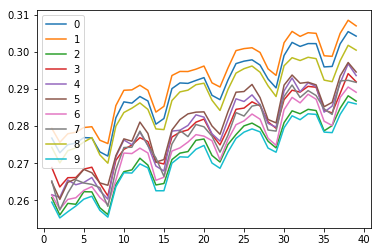

In [15]:
a=show_valid(1)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

3003nb_conv_fold{}_False_d478.pkl
3005_rf_fold{}_False_d478.pkl
3001eb_lgb_fold{}_True_d478.pkl
3002nb_lstm_fold{}_False_d478.pkl
3000eb_ridge_fold{}_True_d478.pkl
3002_lstm_fold{}_False_d478.pkl
3006_xgb_fold{}_False_d478.pkl
3003_conv_fold{}_False_d478.pkl
3000_ridge_fold{}_False_d478.pkl
3001_lgb_fold{}_False_d478.pkl
{0: '3000_ridge_fold{}_False_d478.pkl', 1: '3000eb_ridge_fold{}_True_d478.pkl', 2: '3001_lgb_fold{}_False_d478.pkl', 3: '3001eb_lgb_fold{}_True_d478.pkl', 4: '3002_lstm_fold{}_False_d478.pkl', 5: '3002nb_lstm_fold{}_False_d478.pkl', 6: '3003_conv_fold{}_False_d478.pkl', 7: '3003nb_conv_fold{}_False_d478.pkl', 8: '3005_rf_fold{}_False_d478.pkl', 9: '3006_xgb_fold{}_False_d478.pkl'}


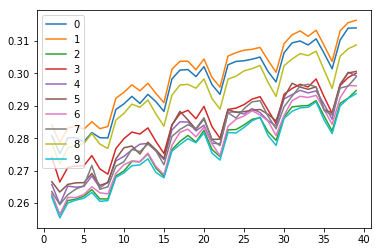

In [16]:
a=show_valid(2)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

3003nb_conv_fold{}_False_d478.pkl
3005_rf_fold{}_False_d478.pkl
3001eb_lgb_fold{}_True_d478.pkl
3002nb_lstm_fold{}_False_d478.pkl
3000eb_ridge_fold{}_True_d478.pkl
3002_lstm_fold{}_False_d478.pkl
3006_xgb_fold{}_False_d478.pkl
3003_conv_fold{}_False_d478.pkl
3000_ridge_fold{}_False_d478.pkl
3001_lgb_fold{}_False_d478.pkl
{0: '3000_ridge_fold{}_False_d478.pkl', 1: '3000eb_ridge_fold{}_True_d478.pkl', 2: '3001_lgb_fold{}_False_d478.pkl', 3: '3001eb_lgb_fold{}_True_d478.pkl', 4: '3002_lstm_fold{}_False_d478.pkl', 5: '3002nb_lstm_fold{}_False_d478.pkl', 6: '3003_conv_fold{}_False_d478.pkl', 7: '3003nb_conv_fold{}_False_d478.pkl', 8: '3005_rf_fold{}_False_d478.pkl', 9: '3006_xgb_fold{}_False_d478.pkl'}


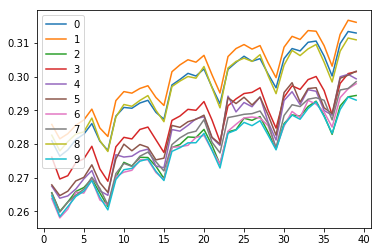

In [17]:
a=show_valid(3)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

3003nb_conv_fold{}_False_d478.pkl
3005_rf_fold{}_False_d478.pkl
3001eb_lgb_fold{}_True_d478.pkl
3002nb_lstm_fold{}_False_d478.pkl
3000eb_ridge_fold{}_True_d478.pkl
3002_lstm_fold{}_False_d478.pkl
3006_xgb_fold{}_False_d478.pkl
3003_conv_fold{}_False_d478.pkl
3000_ridge_fold{}_False_d478.pkl
3001_lgb_fold{}_False_d478.pkl
{0: '3000_ridge_fold{}_False_d478.pkl', 1: '3000eb_ridge_fold{}_True_d478.pkl', 2: '3001_lgb_fold{}_False_d478.pkl', 3: '3001eb_lgb_fold{}_True_d478.pkl', 4: '3002_lstm_fold{}_False_d478.pkl', 5: '3002nb_lstm_fold{}_False_d478.pkl', 6: '3003_conv_fold{}_False_d478.pkl', 7: '3003nb_conv_fold{}_False_d478.pkl', 8: '3005_rf_fold{}_False_d478.pkl', 9: '3006_xgb_fold{}_False_d478.pkl'}


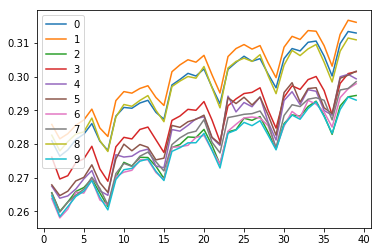

In [18]:
aa=show_valid(4)
df=pd.DataFrame(a)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

In [19]:
def get_data_wo_fold():
    d={}
    for fname in pkldata.keys():
        d[fname]={}
        for offset in range(1,40):
            lst1=[];lst2=[]
            for fold in range(5):
                validdf,testdf=get_valid_data(fname,offset,fold,return_test=True)
                lst1.append(validdf)
                lst2.append(testdf)
            validdf=pd.concat(lst1)
            testdf=pd.concat(lst2)
            if np.random.random()<0.2:
                print fname,offset,validdf.shape, validdf.dropna().shape, testdf.shape
            d[fname][offset]=[validdf.dropna(),testdf]
    return d
pkdata_wo_fold=get_data_wo_fold()

3003nb_conv_fold{}_False_d478.pkl 5 (245292, 2) (209441, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 12 (245292, 2) (203998, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 13 (245292, 2) (203582, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 15 (245292, 2) (217573, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 17 (245292, 2) (200892, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 20 (245292, 2) (199066, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 30 (245292, 2) (196102, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 34 (245292, 2) (190132, 2) (4145, 1)
3003nb_conv_fold{}_False_d478.pkl 39 (245292, 2) (186793, 2) (4145, 1)
3005_rf_fold{}_False_d478.pkl 14 (211526, 2) (211526, 2) (4145, 1)
3005_rf_fold{}_False_d478.pkl 16 (210100, 2) (210100, 2) (4145, 1)
3005_rf_fold{}_False_d478.pkl 18 (204790, 2) (204790, 2) (4145, 1)
3005_rf_fold{}_False_d478.pkl 20 (203828, 2) (203828, 2) (4145, 1)
3005_rf_fold{}_False_d478.pkl 25 (200380, 2) (200380, 2) (4145, 1)
3005_rf_fold{}_False_d478.p

In [81]:
def MSE(y,ypred):
    ind= (~np.isnan(y)) & (~np.isnan(ypred))
    y=y[ind]
    ypred=ypred[ind]
    return mean_squared_error(y,ypred)
def make_l2_features_by_model(filename, pkdata_wo_fold,offset):
    lst1=[];lst2=[]
    for fold in range(5):
        validdf,testdf=get_valid_data(filename,offset,fold,return_test=True)
        lst1.append(validdf)
        lst2.append(testdf)
    valid=pd.concat(lst1)
    #print valid.columns
    y=valid['ytrue'].values
    print valid.corr()
    print valid.mean(),valid.dtypes
    display(valid.head())
    asfd
    valid=valid.drop('ytrue',axis=1)
    print filename, MSE(y,valid.iloc[:,0].values)
    test=reduce(lambda u,v: u+v,lst2)/len(lst2)
    test['idx']=test.index.map(lambda u: tuple([u,478]))
    test=test.set_index('idx')
    total=pd.concat([valid,test])
    arr=np.zeros([829,517],dtype=np.float32)*np.nan
    #print total.index
    index=total.index.map(lambda u: tuple([u[0],u[1]+offset-1]))
    arr[zip(*index)]=total.iloc[:,0].values
    return arr
def make_l2_features(pkdata_wo_fold,offset):
    cols=list(pkdata_wo_fold.keys())
    lst=[]
    for col in cols:
        arr=make_l2_features_by_model(col,pkdata_wo_fold,offset)
        lst.append(arr)
    return cols, np.array(lst)


In [82]:
for offset in range(2,4):
    print offset,
    a,b=make_l2_features( pkdata_wo_fold,offset)

2                                    3003nb_conv_fold{}_False_d478.pkl     ytrue
3003nb_conv_fold{}_False_d478.pkl                           1.000000  0.777799
ytrue                                                       0.777799  1.000000
3003nb_conv_fold{}_False_d478.pkl    2.756540
ytrue                                2.831097
dtype: float64 3003nb_conv_fold{}_False_d478.pkl    float64
ytrue                                float32
dtype: object


3003nb_conv_fold{}_False_d478.pkl     ytrue
(761, 314)                           3.673372  3.332205
(825, 318)                           2.863791  2.995732
(626, 448)                           3.805271  3.828641
(36, 294)                            2.016277  2.564949
(548, 475)                           2.270578  2.639057

NameError: global name 'asfd' is not defined

In [59]:
for offset in range(1,40):
    print offset,
    a,b=make_l2_features( pkdata_wo_fold,offset)
    np.savez_compressed("../input/l1_prediction_offset{}.npz".format(offset),columns=a,arr=b)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39


In [60]:
str(a)

"['3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl']"

In [45]:
str(a)

"['3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl']"

In [30]:
#c=make_l2_features_by_model('3001_lgb_fold{}_False_d478.pkl', pkdata_wo_fold,2)

In [35]:
def show_valid():
    d={}
    for fname in pkdata_wo_fold.keys():
        print fname
        d[fname]={}
        for offset in range(1,40):
            validdf,_=pkdata_wo_fold[fname][offset]
            ns=validdf.shape[0]
            validdf=validdf.dropna()
            if ns <> validdf.shape[0]:
                print "Drop {} records for ".format(ns-validdf.shape[0]),fname,offset,fold
                pass
            score=mean_squared_error(validdf.values[:,0],validdf.values[:,1])
            d[fname][offset]=score
    return d

3003nb_conv_fold{}_False_d478.pkl
3005_rf_fold{}_False_d478.pkl
3001eb_lgb_fold{}_True_d478.pkl
3002nb_lstm_fold{}_False_d478.pkl
3000eb_ridge_fold{}_True_d478.pkl
3002_lstm_fold{}_False_d478.pkl
3006_xgb_fold{}_False_d478.pkl
3003_conv_fold{}_False_d478.pkl
3000_ridge_fold{}_False_d478.pkl
3001_lgb_fold{}_False_d478.pkl
{0: '3000_ridge_fold{}_False_d478.pkl', 1: '3000eb_ridge_fold{}_True_d478.pkl', 2: '3001_lgb_fold{}_False_d478.pkl', 3: '3001eb_lgb_fold{}_True_d478.pkl', 4: '3002_lstm_fold{}_False_d478.pkl', 5: '3002nb_lstm_fold{}_False_d478.pkl', 6: '3003_conv_fold{}_False_d478.pkl', 7: '3003nb_conv_fold{}_False_d478.pkl', 8: '3005_rf_fold{}_False_d478.pkl', 9: '3006_xgb_fold{}_False_d478.pkl'}


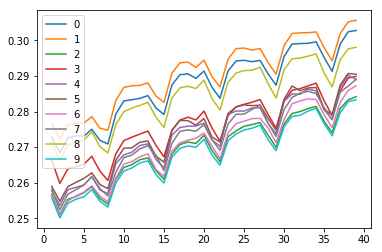

In [38]:
aa=show_valid()
df=pd.DataFrame(aa)
print dict([u for u in (enumerate(df.columns))])
df.columns=range(df.shape[1])
df.plot()

In [39]:
def get_valid_pred(offset):
    lst=[]
    for fname in pkdata_wo_fold:
        s=pkdata_wo_fold[fname][offset][0]
        lst.append(s)
    df=pd.concat(lst,axis=1)
    return df

In [40]:
def evaluate(offset):
    a=get_valid_pred(offset)
    a=a.dropna()
    X=a[[u for u in a.columns if u<>'ytrue']].values
    y=a['ytrue'].iloc[:,0].values
    W=rrvf.make_weights(X.T,y,np.ones_like(y))
    return dict(zip([u for u in a.columns if u<>'ytrue'],W))


In [41]:
lst={}
for offset in range(1,40):
    print offset
    lst[offset]=evaluate(offset)

1
individual loss [ 0.2579667   0.26992994  0.26465823  0.25895021  0.27462005  0.25769033
  0.25426743  0.25613749  0.27105518  0.25526603]
[  1.07953624e-01   1.08932407e-18  -7.41154672e-19   3.89441064e-02
   2.15844956e-17   2.10343076e-01   2.82711110e-01   2.00597673e-01
   0.00000000e+00   1.59450412e-01] 0.249524288772
2
individual loss [ 0.25212982  0.26468841  0.25799685  0.25473185  0.27015897  0.25355737
  0.24854304  0.25051108  0.26653707  0.249484  ]
[  9.70225592e-02  -4.87402273e-18   0.00000000e+00   3.55663063e-02
  -1.10880113e-17   1.84380993e-01   2.78097320e-01   2.21236786e-01
   6.48261074e-19   1.83696035e-01] 0.243851358954
3
individual loss [ 0.2564437   0.26894009  0.2621044   0.25887638  0.2742422   0.2580229
  0.25253949  0.25452629  0.27077304  0.25373219]
[  1.18855657e-01   5.95913634e-18   0.00000000e+00   1.32353868e-02
   3.96599947e-18   1.70609533e-01   3.28024078e-01   2.23243777e-01
  -3.26502298e-18   1.46031569e-01] 0.24817046742
4
individual

individual loss [ 0.28065848  0.29132379  0.28200508  0.28164924  0.29647635  0.28097261
  0.27469721  0.27805011  0.29326414  0.27571471]
[  8.56733390e-02   1.20690754e-18  -3.46944695e-18   7.33551001e-02
  -4.26180268e-17   6.75069793e-02   3.42994619e-01   2.47000733e-01
   1.77736536e-18   1.83469229e-01] 0.270924999276
27
individual loss [ 0.28204483  0.29206247  0.28262191  0.28176138  0.29692978  0.28107093
  0.2754821   0.27816646  0.29361131  0.27625668]
[  8.15246886e-02  -7.59869978e-18   0.00000000e+00   3.17727824e-02
   2.57396894e-17   9.99456514e-02   3.19846530e-01   2.70561446e-01
   8.67905609e-20   1.96348901e-01] 0.271582740424
28
individual loss [ 0.27694193  0.28768451  0.27869784  0.27807433  0.29320464  0.27662583
  0.27160084  0.27547993  0.29010857  0.27291777]
[  1.36212115e-01   6.56930564e-18   2.65650606e-03   0.00000000e+00
  -3.01530775e-17   1.42414767e-01   3.77799237e-01   2.02321329e-01
  -4.04020760e-22   1.38596045e-01] 0.267994195296
29
individ

{0: '3000_ridge_fold{}_False_d478.pkl', 1: '3000eb_ridge_fold{}_True_d478.pkl', 2: '3001_lgb_fold{}_False_d478.pkl', 3: '3001eb_lgb_fold{}_True_d478.pkl', 4: '3002_lstm_fold{}_False_d478.pkl', 5: '3002nb_lstm_fold{}_False_d478.pkl', 6: '3003_conv_fold{}_False_d478.pkl', 7: '3003nb_conv_fold{}_False_d478.pkl', 8: '3005_rf_fold{}_False_d478.pkl', 9: '3006_xgb_fold{}_False_d478.pkl'}


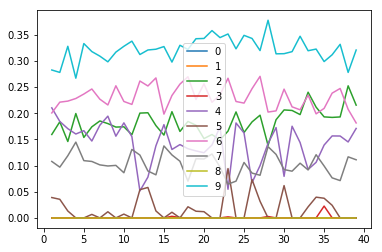

In [42]:
df=pd.DataFrame(lst).T
print dict(enumerate(df.columns))
df.columns=range(df.shape[1])
df.plot()

In [ ]:
aa=get_

In [43]:
lr=Ridge(fit_intercept=False)
lr.fit(X,y)

NameError: name 'X' is not defined

In [ ]:
mean_squared_error(y,lr.predict(X))

In [ ]:
np.sqrt(0.24903703505562438)

In [ ]:
zip([u for u in a.columns if u<>'ytrue'],lr.coef_)

In [150]:
import lightgbm as lgb

In [151]:
lr=lgb.LGBMRegressor(n_estimators=1000,learning_rate=0.05,num_leaves=63)

In [153]:
X.shape[0]*.7

169125.59999999998

In [156]:
X.shape,y.shape

((241608, 9), (241608,))

In [160]:
np.sqrt(mean_squared_error(lr.predict(X[:169125]),y[:169125])),np.sqrt(mean_squared_error(lr.predict(X[169125:]),y[169125:]))

(0.48866422391158787, 0.49558654348874881)

In [161]:
for u in X.T:
    print np.sqrt(mean_squared_error(u,y))

0.507904221906
0.519547822152
0.51444944065
0.524042031941
0.507632085025
0.504249373971
0.506100278102
0.520629598633
0.505238582527


In [157]:
lr.fit(X[:169125],y[:169125],eval_set=[(X[169125:],y[169125:])],early_stopping_rounds=30)

[1]	valid_0's l2: 0.630626
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's l2: 0.593435
[3]	valid_0's l2: 0.559893
[4]	valid_0's l2: 0.529566
[5]	valid_0's l2: 0.502154
[6]	valid_0's l2: 0.477447
[7]	valid_0's l2: 0.455108
[8]	valid_0's l2: 0.434908
[9]	valid_0's l2: 0.416693
[10]	valid_0's l2: 0.400193
[11]	valid_0's l2: 0.385312
[12]	valid_0's l2: 0.371888
[13]	valid_0's l2: 0.359766
[14]	valid_0's l2: 0.348789
[15]	valid_0's l2: 0.338879
[16]	valid_0's l2: 0.329931
[17]	valid_0's l2: 0.321841
[18]	valid_0's l2: 0.314545
[19]	valid_0's l2: 0.30794
[20]	valid_0's l2: 0.301978
[21]	valid_0's l2: 0.296579
[22]	valid_0's l2: 0.291738
[23]	valid_0's l2: 0.28733
[24]	valid_0's l2: 0.283368
[25]	valid_0's l2: 0.279772
[26]	valid_0's l2: 0.27651
[27]	valid_0's l2: 0.273567
[28]	valid_0's l2: 0.27091
[29]	valid_0's l2: 0.2685
[30]	valid_0's l2: 0.266334
[31]	valid_0's l2: 0.264373
[32]	valid_0's l2: 0.26259
[33]	valid_0's l2: 0.260965
[34]	valid_0's l2: 0.259503
[3

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.05, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=1000,
       n_jobs=-1, num_leaves=63, objective=None, random_state=None,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=1)

In [100]:
import gc
gc.collect()

0

In [103]:
1

1